# Pilot Study: Interaction analysis with DESeq2

## Synposis

In this tutorial, we will illustrate the use of the DESeq2 package for conducting interaction analysis. More specifically, for each gene we will assess the level of statistical evidence to support a treatment by strain interaction with respect to the mRNA abudnance for that gene.

In the context of our pilot experiment, for a given gene, let $\Delta_{H99}$ denote the differential expression effect due to treatment in the H99 strain and $\Delta_{mar1d} denote the corresponding differential expression effect in the mar1d strain. A 

If the differential expression effect is quantified by say log2 fold-change, then
* testing for a differential treatment effect within the H99 strain can be formulated as testing $H_0: \Delta_{H99} = 0$
against  $H_1: \Delta_{H99} \ne 0$. 
* testing for a differential treatment effect within the mar1d strain can be formulated as testing $H_0: \Delta_{mar1d} = 0$ against  $H_1: \Delta_{mar1d} \ne 0$
* testing for a treatment by strain interaction with respect to mRNA abundance of the gene can be formulated as testing $H_0:  \Delta_{H99} = \Delta_{mar1d}$ against  $H_1: \Delta_{H99} \ne \Delta_{mar1d}$. 

The (margional) differential expression hypothesis tests whether there is evidence for a fold change, while the interaction hypothesis tests whether there is a difference between the two fold changes. For example $\Delta_{H99}  >\Delta_{mar1d}$ indicates that the differential expression effect due to treatment is larger in the H99 strain compared to the mar1d strain.


## Set Environment

In [1]:
source("pilot_config.R")
source("pilot_util.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following o

## Load and create data objects

### Attach data objects containing count and meta data

In [2]:
attach(file.path(OUTDIR, "HTS-Pilot-Annotated-STAR-counts.RData"))

### Create columnData object

In [3]:
annomapres0 %>%
    dplyr::filter(enrichment_method == "RZ")  %>%
    DataFrame ->
    columnData
rownames(columnData) <- columnData[["Label"]]

columnData[, c("Label", "Strain", "Media")] %>% head(3)

DataFrame with 3 rows and 3 columns
              Label   Strain    Media
        <character> <factor> <factor>
1_RZ_J       1_RZ_J      H99      YPD
10_RZ_C     10_RZ_C    mar1d      YPD
11_RZ_J     11_RZ_J    mar1d      YPD

### Create countData objects

In [4]:
annogenecnts0 %>%
    dplyr::select(dput(as.character(c("gene", columnData[["Label"]])))) %>%
    as.data.frame %>%
    column_to_rownames("gene") %>%
    as.matrix ->
    countData

countData %>% head(3)

c("gene", "1_RZ_J", "10_RZ_C", "11_RZ_J", "12_RZ_P", "13_RZ_J", 
"14_RZ_C", "15_RZ_C", "16_RZ_P", "2_RZ_C", "21_RZ_C", "22_RZ_C", 
"23_RZ_J", "24_RZ_J", "26_RZ_C", "27_RZ_P", "3_RZ_J", "35_RZ_P", 
"36_RZ_J", "38_RZ_P", "4_RZ_P", "40_RZ_J", "45_RZ_P", "47_RZ_P", 
"9_RZ_C")


,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,204,76,92,64,230,182,200,129,168,124,⋯,43,107,150,109,95,51,235,122,112,106
CNAG_00003,40,24,18,34,56,53,54,40,40,41,⋯,9,24,26,43,43,11,53,46,41,35


## Interaction Analysis 

Note that the Media by Strain interaction term has been added to the model. In the design argument, the additive model (Median + Strain) has been augmented with the interaction term (Media:Strain). The latter should appear last as it is our primary parameter of interest. In statistics, Media + Strain is referred to as the additive model while Media + Strain + Media:Strain is referred to as the multiplicative model.

In [5]:
ddsmult <- DESeqDataSetFromMatrix(countData, columnData, ~ Media + Strain + Media:Strain)
ddsmult <- estimateSizeFactors(ddsmult)
ddsres <- DESeq(ddsmult)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Verify the design before looking at the results

In [6]:
design(ddsres)

~Media + Strain + Media:Strain

We retrieve the top twenty genes, according to their corresponding adjusted P-values

In [6]:
results(ddsres, tidy=TRUE) %>%
    arrange(padj) %>%
    head(20) ->
    tophits

tophits

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.86196,4.0231182,0.29759976,13.518553,1.215429e-41,9.552054e-38
CNAG_05459,636.02477,1.1440422,0.09994094,11.447183,2.429119e-30,9.545224e-27
CNAG_03621,1821.27006,-1.0644341,0.10659585,-9.985699,1.760551e-23,4.612056e-20
CNAG_00600,848.44047,1.1424338,0.11598632,9.849729,6.872879e-23,1.350349e-19
CNAG_04585,812.31911,-4.0407468,0.41261597,-9.792997,1.206656e-22,1.896623e-19
CNAG_03735,521.96604,1.6342312,0.16755798,9.753228,1.786944e-22,2.340599e-19
CNAG_07862,85.91321,-2.6088443,0.26841617,-9.719401,2.492446e-22,2.798304e-19
CNAG_02733,15.32034,-4.0236397,0.41731949,-9.641629,5.333480e-22,5.239478e-19
CNAG_06517,850.38128,1.8719912,0.19539060,9.580764,9.632973e-22,8.411726e-19
CNAG_00399,213.68536,-2.1466008,0.22469243,-9.553507,1.253786e-21,9.853503e-19


Retrieve the gene symbols for the the top and twentieth ranked hits and assign them to the vector topgenes

In [7]:
topgenes <- tophits$row[c(1,20)]
topgenes

[1] "CNAG_04307" "CNAG_05192"

## Visualize Interactions

First, we "normalize" the counts using the vst method (this is an alternative to the rlog method)

In [9]:
vstexp <- vst(ddsmult, blind=TRUE)

Next, we visualize the results using dotplots. It is noted that this is an exploratory analysis meant to help us visualize the findings.

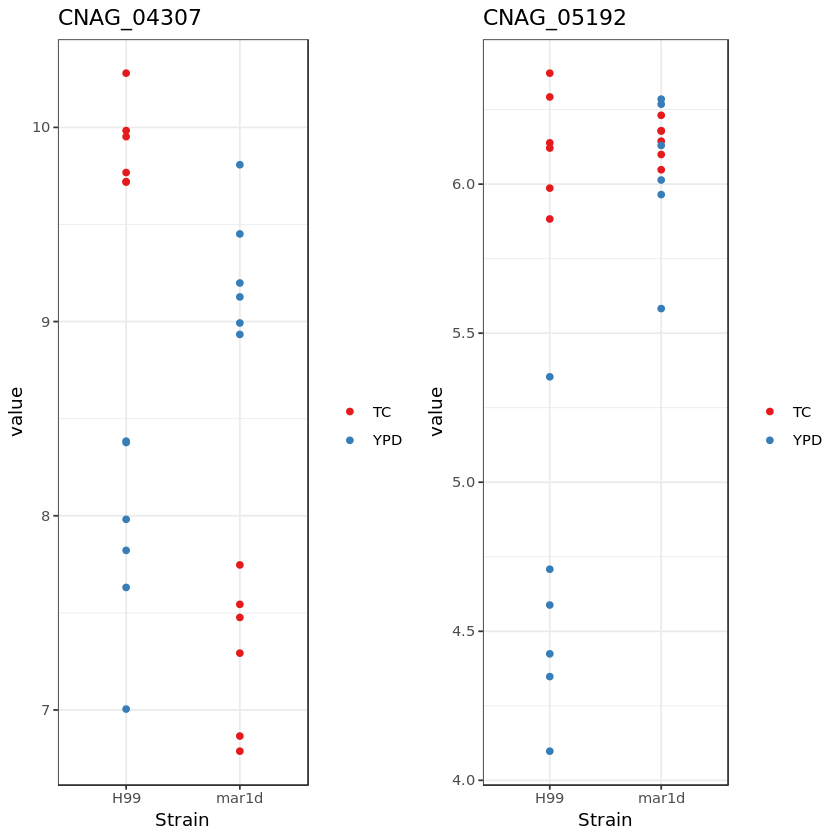

In [10]:
p1 <- myinteractplot(vstexp, topgenes[1], "strain")
p2 <- myinteractplot(vstexp, topgenes[2], "strain")
grid.arrange(p1, p2, ncol = 2) 

Observations:

* CNAG_04307: We observe that in the H99 strain, treatment seemingly upregulates expression while decreasing expression in the mar1d strain. While the effect sizes are seemingly similar in absolute magnitude, they are in the opposite direction. 
* CNAG_05192: We observe that in the H99 strain, treatment seemingly upregulates expression. There is seemingly no treatment effect in the mar1d strain

## Estimate treatment effect size within each strain

Next, we will show how to estimate treatment effect sizes within each strain. To keep things clean, we make a new copy of the ddsmult object and name it dds. We will add a new variable, to be named group, containing the combined Media and Strain assignments to this new copy and replace its design with group. 

In [11]:
dds <- ddsmult
dds$group <- as.factor(paste0(dds$Media,dds$Strain))
design(dds) <- ~ group
ddsgrp <- DESeq(dds)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Let's look at the first 5 cases. As expected, the entry in group is obtained by pasting strain status to the right of treatment status.

In [13]:
dds@colData[1:5, c("Label", "Media", "Strain", "group")]

DataFrame with 5 rows and 4 columns
              Label    Media   Strain    group
        <character> <factor> <factor> <factor>
1_RZ_J       1_RZ_J      YPD      H99   YPDH99
10_RZ_C     10_RZ_C      YPD    mar1d YPDmar1d
11_RZ_J     11_RZ_J      YPD    mar1d YPDmar1d
12_RZ_P     12_RZ_P      YPD    mar1d YPDmar1d
13_RZ_J     13_RZ_J       TC      H99    TCH99

Let's compare the designs:

In [13]:
ddsmult@design
dds@design

~Media + Strain + Media:Strain

~group

Next, we retrieve the results for the interaction analysis (r0), the results for contrasting the treatment effect within H99 (r1) and the results for constrasting the treatment effect within mar1d (r2).

In [16]:
### Results for interaction analysis
r0<-results(ddsres, tidy=TRUE)
### Contrast treatments within H99 strain
r1<-results(ddsgrp, contrast = c("group", "TCH99", "YPDH99"), tidy=TRUE)
### Contrast treatments within mar1d strain
r2<-results(ddsgrp, contrast = c("group", "TCmar1d", "YPDmar1d"), tidy=TRUE)

Now, let's look at the results for the two genes we had picked

In [19]:
### Look at the results for top two genes
r0 %>% filter(row %in% topgenes)
r1 %>% filter(row %in% topgenes)
r2 %>% filter(row %in% topgenes)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.8620,4.023118,0.2975998,13.518553,1.215429e-41,9.552054e-38
CNAG_05192,50.2723,1.859587,0.2446109,7.602225,2.910827e-14,1.143809e-11


row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.8620,2.013216,0.2107145,9.554234,1.245011e-21,9.241900e-20
CNAG_05192,50.2723,1.953382,0.1997372,9.779762,1.375341e-22,1.252967e-20


row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.8620,-2.00990294,0.2101548,-9.5639165,1.133828e-21,1.934022e-19
CNAG_05192,50.2723,0.09379498,0.1412074,0.6642357,5.065395e-01,5.972830e-01


* CNAG_04307: We observe that the estimated effect size in the H99 strain (2.01) is positive. The corresponding estimated effect size (-2.01) in the mar1d strain is negative. Constrast the estimated magnitudes and estimated directions to the figure
    - The P-value for testing for a differential expression within H99 ($H_0: \Delta_{H99} = 0$ against  $H_1: \Delta_{H99} \ne 0$) is 9.55e-38 (appropriately presented as < 2.22e-16)
    - The P-value for testing for a differential expression within mar1d ($H_0: -\Delta_{mar1d} = 0$ against  $H_1: \Delta_{mar1d} \ne 0$) is 1.9e-19 (appropriately presented as < 2.22e-16)
    - The P-value for a treatment by strain interaction with respect to the mRNA abundance of CNAG_04307 is 9.55e-38 appropriately presented as < 2.22e-16)

* CNAG_05192: We observe that the estimated effect size in the H99 strain (2.01) is positive. The estimated effect size in the mar1d strain is very small (0.093).
  - The P-value for testing for a differential expression within H99 ($H_0: \Delta_{H99} = 0$ against  $H_1: \Delta_{H99} \ne 0$) is 1.25e-20 (appropriately presented as < 2.22e-16)
  - The P-value for testing for a differential expression within mar1d ($H_0: -\Delta_{mar1d} = 0$ against  $H_1: \Delta_{mar1d} \ne 0$) is 0.51 (note that you may _not_ conclude that there is no differential expression in the mar1d strain)
  - The P-value for a treatment by strain interaction with respect to the mRNA abundance of CNAG_04307 is 1.14e-11.